In [55]:
import numpy as np
np.random.seed(12345)

N = 200
x1 = np.random.uniform(-1.5, -0.5, size = [ N // 2, 1 ])
x2 = np.random.uniform(0.5, 1.5, size = [ N // 2, 1 ])
x_train = np.concatenate([x1, x2], axis=0)
x_pred = np.linspace(-3, 3, 200).reshape(-1, 1)

def f(x):
    return np.sin((x - 0.5) * 10) + np.cos((x + 0.2) * 5)

noise_scale = 0.2
y_train = f(x_train) + np.random.normal(0.0, noise_scale, size = [ N, 1 ])
y_train = y_train.squeeze()

In [103]:
signal_scale = 1.2
length_scale = 0.7

def k(x, y):
    sq_dist = np.sum(((x[:, None] / length_scale) - (y[None, :] / length_scale)) ** 2, axis=-1)
    dist = np.sqrt(sq_dist)
    norm_term = np.sqrt(3.0) * dist + 1.0
    exponential_term = np.exp(-np.sqrt(3.0) * dist)
    return (signal_scale ** 2) * norm_term * exponential_term

K = k(x_train, x_train)
alpha_exact = np.linalg.solve(K + noise_scale ** 2 * np.eye(N), y_train)
y_pred_exact = k(x_pred, x_train) @ alpha_exact

In [113]:
lr = 0.001
momentum = 0.9
polyak = 1e-2
iterations = 3000
B = 10

alpha = np.zeros((N,))
alpha_polyak = np.zeros((N,))
v = np.zeros((N,))

def g(params, idx):
    K_batch = k(x_train[idx], x_train)
    grad = np.zeros((N,))
    grad[idx] = K_batch @ params - y_train[idx] + (noise_scale ** 2) * params[idx]
    return (N / B) * grad

def update(params, params_polyak, velocity, idx):
    grad = g(params, idx)
    velocity = momentum * velocity - lr * grad
    params = params + velocity
    params_polyak = polyak * params + (1.0 - polyak) * params_polyak
    return params, params_polyak, velocity

for i in range(iterations):
    idx = np.random.choice(N, size=(B,), replace=False)
    alpha, alpha_polyak, v = update(alpha, alpha_polyak, v, idx)

y_pred_sdd = k(x_pred, x_train) @ alpha_polyak


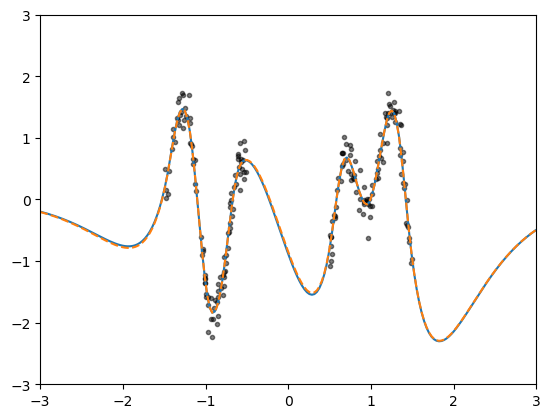

In [114]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-3.0, 3.0)
ax.set_ylim(-3.0, 3.0)
ax.plot(x_train, y_train, '.', color='k', alpha=0.5)
ax.plot(x_pred, y_pred_exact, linestyle='-', color='tab:blue')
ax.plot(x_pred, y_pred_sdd, linestyle='--', color='tab:orange')